In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from nltk import PorterStemmer, word_tokenize
from nltk.corpus import stopwords
import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
import joblib

In [2]:
from sklearn.metrics import confusion_matrix
def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")

In [3]:
def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")


In [53]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.rcParams.update({'font.size': 20})
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [4]:
train_data = pd.read_csv('data/wassa_train.csv')
test_data = pd.read_csv('data/wassa_test.csv')
val_data = pd.read_csv('data/wassa_val.csv')

In [5]:
train_data

,id,tweet,emotion
0,1929,Kinda wished I watched mischievous kiss before...,joy
1,4049,When you forget to mention you were bought dre...,anger
2,5405,@FreyaLynn @donniewahlberg yep! jimmy buffett ...,neutral
3,5900,"@philcampbell blue skies? where, it's still gr...",neutral
4,3712,Some moving clips on youtube tonight of the vi...,anger
...,...,...,...
5996,5407,@koifusionpdx i was so close to the tacos...on...,neutral
5997,496,@Fatumoriginal there's no sitcom better! If u ...,sadness
5998,499,@Mysteri759 @Ren102e906 @slb42jcb @swoozyqyah ...,sadness
5999,1784,Watch this amazing live.ly broadcast by @ittzd...,joy


In [6]:
def preprocess_text(text):
    result = text.lower()
    result = result.strip()
    result = re.result = re.sub(r"http\S+", "", result)
    result = re.sub('\S*@\S*\s?', '', result)
    result = unidecode.unidecode(result)
    stop_words = stopwords.words("english")
    word_list = word_tokenize(result)

    stemmed_sentence = ""
    for word in word_list:
        if word not in stop_words:
            stemmed_sentence += word
            stemmed_sentence += " "

    result = stemmed_sentence
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result = ''.join(filter(whitelist.__contains__, result))
    result = ''.join([i for i in result if not i.isdigit()])
    return result

In [7]:
def preprocess_text_list(text_list):
  for i,text in enumerate(text_list):
    text_list[i] = preprocess_text(text_list[i])

In [26]:
train_texts = train_data["tweet"].tolist()
val_texts = val_data["tweet"].tolist()
test_texts = test_data["tweet"].tolist()


train_labels = train_data["emotion"].tolist()
val_labels = val_data["emotion"].tolist()
test_labels = test_data["emotion"].tolist()

train_labels[:10]
     

['joy',
 'anger',
 'neutral',
 'neutral',
 'anger',
 'joy',
 'neutral',
 'sadness',
 'sadness',
 'neutral']

In [27]:
preprocess_text_list(train_texts)
preprocess_text_list(val_texts)
preprocess_text_list(test_texts)

train_texts[:10]

['kinda wished watched mischievous kiss playful kiss ',
 'forget mention bought dreamboys tickets ',
 'yep  jimmy buffett ftw     jimmy needs tweet words wisdom every morning ',
 'blue skies   s still grey hazy window ',
 'moving clips youtube tonight vigil held tulsa metropolitan baptist church  terencecruther  justice  sadness ',
 'makes successful  happy forever ',
 'morning hon  breakfast  cant decide ',
 'standard candice starting show pout  startasyoumeantogoon  gbbo ',
 '   would frown bit  folding arms  why every time m need assistance someone expects lil   ',
 'someone make cofffeeeeeee  ']

In [28]:
 vectorizer = TfidfVectorizer()
 vectorizer.fit(train_texts)

TfidfVectorizer()

In [29]:
vectorized_train_texts = vectorizer.transform(train_texts)
vectorized_val_texts = vectorizer.transform(val_texts)
vectorized_test_texts = vectorizer.transform(test_texts)

In [30]:
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
encoded_test_labels = label_encoder.transform(test_labels)

In [31]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam', random_state=42)
mlp_model.fit(vectorized_train_texts, encoded_train_labels)


MLPClassifier(max_iter=300, random_state=42)

In [32]:
y_pred = mlp_model.predict_proba(vectorized_test_texts)
y_pred

array([[3.05445346e-07, 1.02690574e-06, 8.05369170e-07, 1.82345827e-06,
        9.99996039e-01],
       [9.71791293e-01, 1.11290332e-03, 4.07191813e-05, 2.66940322e-02,
        3.61052323e-04],
       [1.16510914e-02, 3.65246494e-02, 5.32468685e-04, 9.50738313e-01,
        5.53477931e-04],
       ...,
       [1.93770608e-06, 9.99994279e-01, 4.03483905e-07, 2.78092325e-06,
        5.98530430e-07],
       [5.59203362e-05, 9.99835854e-01, 2.42315261e-05, 6.76086374e-05,
        1.63853493e-05],
       [3.33323311e-01, 6.65484845e-01, 2.21058536e-04, 2.52349830e-04,
        7.18435675e-04]])

In [37]:
acc = accuracy_score(encoded_test_labels, np.argmax(y_pred, axis=1))
precision = precision_score(encoded_test_labels, np.argmax(y_pred, axis=1), average="macro")
recall = recall_score(encoded_test_labels, np.argmax(y_pred, axis=1), average="macro")
f1 = f1_score(encoded_test_labels, np.argmax(y_pred, axis=1), average="macro")
print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")


Model has acc = 0.8346666666666667
, precision = 0.8394945063007496
, recall = 0.8346666666666668
, f1_score = 0.8360157679619695



In [49]:
predicted_labels = mlp_model.predict(vectorized_test_texts)

In [36]:
report = classification_report(encoded_test_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       150
           1       0.81      0.82      0.82       150
           2       0.95      0.83      0.88       150
           3       0.70      0.75      0.72       150
           4       0.89      0.90      0.89       150

    accuracy                           0.83       750
   macro avg       0.84      0.83      0.84       750
weighted avg       0.84      0.83      0.84       750



In [57]:
predicted_labels = mlp_model.predict(vectorized_test_texts)

decoded_predicted_labels = label_encoder.inverse_transform(predicted_labels)

report = classification_report(test_labels, decoded_predicted_labels)
print(report)

              precision    recall  f1-score   support

       anger       0.85      0.87      0.86       150
        fear       0.81      0.82      0.82       150
         joy       0.95      0.83      0.88       150
     neutral       0.70      0.75      0.72       150
     sadness       0.89      0.90      0.89       150

    accuracy                           0.83       750
   macro avg       0.84      0.83      0.84       750
weighted avg       0.84      0.83      0.84       750



In [46]:
labels = ['joy', 'anger', 'fear', 'sadness', 'neutral']

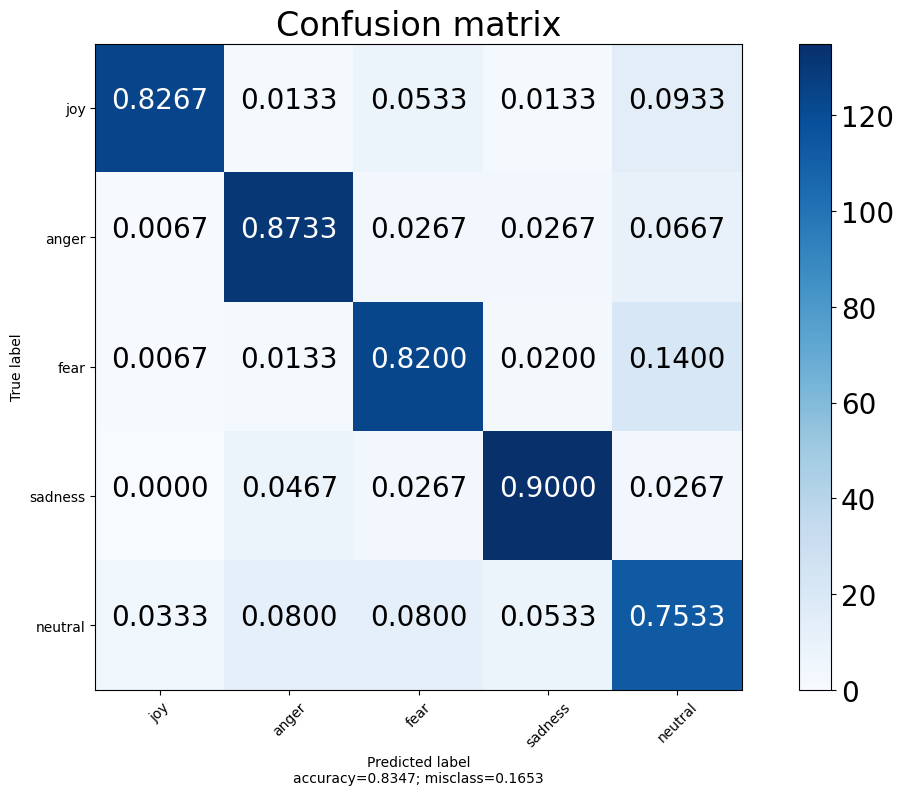

In [54]:
predicted = label_encoder.inverse_transform(predicted_labels)
cm = confusion_matrix(test_labels, predicted, labels=labels)
plot_confusion_matrix(cm, labels)

In [51]:
predicted_emotions = label_encoder.inverse_transform(y_pred.argmax(axis=1))
probabilities = y_pred.max(axis=1)

In [14]:
for text, emotion, prob in zip(test_texts, predicted_emotions, probabilities):
    print(f"Text: {text}\nPredicted Emotion: {emotion} (Probability: {prob:.2f})\n")

Text:  depression  
Predicted Emotion: sadness (Probability: 1.00)

Text: peanut butter takes away sting 
Predicted Emotion: anger (Probability: 0.97)

Text: mannnn  got iphone    im jealous  
Predicted Emotion: neutral (Probability: 0.95)

Text: speech bold coz nt written pm ns bt expressiontone dull n dim 
Predicted Emotion: sadness (Probability: 0.79)

Text: fair 
Predicted Emotion: neutral (Probability: 1.00)

Text: may send copy  herothegreyhound  either ebook real paper one  boy greyhound  smiles  tears  laughter 
Predicted Emotion: joy (Probability: 0.94)

Text: baby going first sleepover tonight m gon na need lot wine get today 
Predicted Emotion: neutral (Probability: 1.00)

Text: stayed home  
Predicted Emotion: sadness (Probability: 1.00)

Text: tomorrowland central nt gotten confirmation m signed star tours  waiting see give shift  
Predicted Emotion: fear (Probability: 0.72)

Text: guy video m shaking 
Predicted Emotion: fear (Probability: 1.00)

Text: cancelling home fibe

In [45]:
emotions = [
    "I hate getting up, it's so annoying.",
    "I love cats and their sweet noses.",
    "I put up with my schoolmates.",
    "This movie made me feel so happy!",
    "The traffic jam today was frustrating.",
    "Spending time with friends always brings joy.",
    "I feel lonely when I'm alone at home.",
    "Excited about the upcoming vacation!",
    "I love spending time with friends and family. It brings me so much joy!",
    "The rude behavior of that person made me really angry.",
    "I'm feeling neutral about the upcoming changes at work.",
    "Today is just another neutral day for me.",
    "The constant delays and issues with the project are making me angry.",
    "Winning the lottery would bring me immense joy and happiness!",
    "I don't have a strong opinion on the matter; I'm feeling quite neutral.",
    "The news about the recent event left me in deep sadness.",
    "Losing a loved one is an experience filled with sadness and grief.",
    "I have a neutral stance on the current political situation.",
    "I'm so happy right now!", "This is really frustrating."
    "Feeling sad and lonely tonight.",
    "I can't contain my excitement!",
    "Angry about the recent events.",
    "Today is a wonderful day!",
    "Dealing with a lot of stress.",
    "The movie made me cry, but it was beautiful.",
    "I'm thrilled about the upcoming project.",
    "Feeling a bit anxious about the presentation."
]

texts = []
predicted_emotions_mlp = []
probabilities_mlp = []

for text in emotions:
    vectorized_text = vectorizer.transform([preprocess_text(text)])
    # vectorized_text = vectorizer.transform([text])
    predictions_proba_mlp = mlp_model.predict_proba(vectorized_text)

    predicted_emotion_mlp = label_encoder.inverse_transform(predictions_proba_mlp.argmax(axis=1))[0]
    probability_mlp = predictions_proba_mlp.max()

    texts.append(text)
    predicted_emotions_mlp.append(predicted_emotion_mlp)
    probabilities_mlp.append(probability_mlp)

emotion_df_mlp = pd.DataFrame({'Text': texts, 'Predicted Emotion (MLP)': predicted_emotions_mlp, 'Probability (MLP)': probabilities_mlp})

emotion_df_mlp

,Text,Predicted Emotion (MLP),Probability (MLP)
0,"I hate getting up, it's so annoying.",sadness,0.668173
1,I love cats and their sweet noses.,joy,0.978282
2,I put up with my schoolmates.,anger,0.314527
3,This movie made me feel so happy!,joy,0.846680
4,The traffic jam today was frustrating.,anger,0.879346
5,Spending time with friends always brings joy.,sadness,0.499188
6,I feel lonely when I'm alone at home.,neutral,0.999533
7,Excited about the upcoming vacation!,neutral,0.984509
8,I love spending time with friends and family. ...,sadness,0.553618
9,The rude behavior of that person made me reall...,anger,0.978150


In [16]:
text = "Today is a wonderful day!	"

vectorized_text = vectorizer.transform([text])

predictions_proba_mlp = mlp_model.predict_proba(vectorized_text)

predicted_emotion_mlp = label_encoder.inverse_transform(predictions_proba_mlp.argmax(axis=1))[0]
probability_mlp = predictions_proba_mlp.max()

sorted_probabilities = sorted(zip(label_encoder.classes_, predictions_proba_mlp.flatten()), key=lambda x: x[1], reverse=True)

print(f"Text: {text}\nPredicted Emotion (MLP): {predicted_emotion_mlp}\nProbability (MLP): {probability_mlp:.2f}")
print(f"Probabilities per class: {sorted_probabilities}")



Text: Today is a wonderful day!	
Predicted Emotion (MLP): neutral
Probability (MLP): 0.59
Probabilities per class: [('neutral', 0.5901470760279687), ('joy', 0.39473060236952245), ('sadness', 0.0073791822165468045), ('fear', 0.005896632866009409), ('anger', 0.0018465065199527284)]


In [17]:
text = """The air crackles with tension, and the world feels like a pressure cooker about to explode. Every step is heavy, and the rhythm of life echoes with the discordant beats of frustration. It's as if the very air is charged with an unsettling energy, ready to unleash the storm that brews within.

The smallest inconveniences become fuel for the fiery furnace of anger, each frustration adding another log to the burning resentment. Words hang in the air, sharp and cutting, like daggers seeking release from the depths of irritation. The world seems painted in shades of red, a visual representation of the simmering rage beneath the surface.

In this moment, control feels elusive, slipping through clenched fists like sand. The desire to scream or slam doors becomes a tempting release, an outlet for the building resentment. The very fabric of patience feels threadbare, stretched to its limit, threatening to unravel at the slightest provocation."""

vectorized_text = vectorizer.transform([text])

predictions_proba_mlp = mlp_model.predict_proba(vectorized_text)

predicted_emotion_mlp = label_encoder.inverse_transform(predictions_proba_mlp.argmax(axis=1))[0]
probability_mlp = predictions_proba_mlp.max()

sorted_probabilities = sorted(zip(label_encoder.classes_, predictions_proba_mlp.flatten()), key=lambda x: x[1], reverse=True)

print(f"Text: {text}\nPredicted Emotion (MLP): {predicted_emotion_mlp}\nProbability (MLP): {probability_mlp:.2f}")
print(f"Probabilities per class: {sorted_probabilities}")



Text: The air crackles with tension, and the world feels like a pressure cooker about to explode. Every step is heavy, and the rhythm of life echoes with the discordant beats of frustration. It's as if the very air is charged with an unsettling energy, ready to unleash the storm that brews within.

The smallest inconveniences become fuel for the fiery furnace of anger, each frustration adding another log to the burning resentment. Words hang in the air, sharp and cutting, like daggers seeking release from the depths of irritation. The world seems painted in shades of red, a visual representation of the simmering rage beneath the surface.

In this moment, control feels elusive, slipping through clenched fists like sand. The desire to scream or slam doors becomes a tempting release, an outlet for the building resentment. The very fabric of patience feels threadbare, stretched to its limit, threatening to unravel at the slightest provocation.
Predicted Emotion (MLP): anger
Probability (ML

In [18]:
text = """In the quietude of solitude, a heavy fog of sadness descends, enveloping the world in a muted palette of gray. Each breath feels like a burden, and the air is thick with the weight of unspoken sorrows. The echo of a distant sigh seems to reverberate through the emptiness, a haunting melody of melancholy.

Every step is laden with the echoes of past heartaches, and the landscape is painted with the brushstrokes of unshed tears. The world, once vibrant and alive, now appears as a desolate tableau, a reflection of the internal storm that rages within. The rhythm of life slows to a somber cadence, mirroring the heavy heart that beats in sync with the sorrowful symphony.

Gazing out through the window, raindrops trace their lonely paths, a metaphor for the tears that refuse to fall. The silence is broken only by the occasional gentle patter, a lullaby for the dispirited soul. The ache is palpable, an emotional bruise that colors every interaction with a tinge of muted blue."""

# Przetworzenie tekstu
vectorized_text = vectorizer.transform([text])

# Predykcja z prawdopodobieństwami
predictions_proba_mlp = mlp_model.predict_proba(vectorized_text)

# Odczytanie emocji z najwyższymi prawdopodobieństwami
predicted_emotion_mlp = label_encoder.inverse_transform(predictions_proba_mlp.argmax(axis=1))[0]
probability_mlp = predictions_proba_mlp.max()

# Sortowanie prawdopodobieństw malejąco
sorted_probabilities = sorted(zip(label_encoder.classes_, predictions_proba_mlp.flatten()), key=lambda x: x[1], reverse=True)

# Wyświetlenie wyników
print(f"Text: {text}\nPredicted Emotion (MLP): {predicted_emotion_mlp}\nProbability (MLP): {probability_mlp:.2f}")
print(f"Probabilities per class: {sorted_probabilities}")



Text: In the quietude of solitude, a heavy fog of sadness descends, enveloping the world in a muted palette of gray. Each breath feels like a burden, and the air is thick with the weight of unspoken sorrows. The echo of a distant sigh seems to reverberate through the emptiness, a haunting melody of melancholy.

Every step is laden with the echoes of past heartaches, and the landscape is painted with the brushstrokes of unshed tears. The world, once vibrant and alive, now appears as a desolate tableau, a reflection of the internal storm that rages within. The rhythm of life slows to a somber cadence, mirroring the heavy heart that beats in sync with the sorrowful symphony.

Gazing out through the window, raindrops trace their lonely paths, a metaphor for the tears that refuse to fall. The silence is broken only by the occasional gentle patter, a lullaby for the dispirited soul. The ache is palpable, an emotional bruise that colors every interaction with a tinge of muted blue.
Predicted 

In [19]:
text = """Waking up to the warm embrace of sunshine, the world seems to sparkle with endless possibilities. A symphony of birdsong dances through the air, creating a melody that resonates with the rhythm of joy. Today is not just a day; it's a canvas waiting to be painted with vibrant hues of happiness.

As I step outside, a gentle breeze carries whispers of optimism, and the flowers in bloom release a fragrance that feels like nature's way of smiling. There's an infectious energy in the atmosphere, a reminder that life is a grand celebration, and every moment is a chance to dance to the melody of our own existence.

In the midst of this symphony of joy, even the mundane becomes extraordinary. The rhythmic tapping of my footsteps on the pavement transforms into a cheerful beat, syncopating with the pulse of life. The world seems to applaud my every move, as if nature itself is cheering me on.

Meeting the gaze of a stranger, there's a shared recognition of the beauty that surrounds us. It's as if joy is a secret language, and we are all fluent in its expression. Laughter becomes the currency of the day, exchanged freely between friends and strangers alike, creating a tapestry of shared happiness."""

vectorized_text = vectorizer.transform([text])

predictions_proba_mlp = mlp_model.predict_proba(vectorized_text)

predicted_emotion_mlp = label_encoder.inverse_transform(predictions_proba_mlp.argmax(axis=1))[0]
probability_mlp = predictions_proba_mlp.max()

sorted_probabilities = sorted(zip(label_encoder.classes_, predictions_proba_mlp.flatten()), key=lambda x: x[1], reverse=True)

print(f"Text: {text}\nPredicted Emotion (MLP): {predicted_emotion_mlp}\nProbability (MLP): {probability_mlp:.2f}")
print(f"Probabilities per class: {sorted_probabilities}")



Text: Waking up to the warm embrace of sunshine, the world seems to sparkle with endless possibilities. A symphony of birdsong dances through the air, creating a melody that resonates with the rhythm of joy. Today is not just a day; it's a canvas waiting to be painted with vibrant hues of happiness.

As I step outside, a gentle breeze carries whispers of optimism, and the flowers in bloom release a fragrance that feels like nature's way of smiling. There's an infectious energy in the atmosphere, a reminder that life is a grand celebration, and every moment is a chance to dance to the melody of our own existence.

In the midst of this symphony of joy, even the mundane becomes extraordinary. The rhythmic tapping of my footsteps on the pavement transforms into a cheerful beat, syncopating with the pulse of life. The world seems to applaud my every move, as if nature itself is cheering me on.

Meeting the gaze of a stranger, there's a shared recognition of the beauty that surrounds us. It'

In [24]:
joblib.dump(mlp_model, 'mlp_model.joblib')
joblib.dump(vectorizer, 'vectorizer.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

In [13]:
loaded_mlp_model = joblib.load('models/mlp_model/mlp_model.joblib')
loaded_vectorizer = joblib.load('models/mlp_model/vectorizer.joblib')
loaded_label_encoder = joblib.load('models/mlp_model/label_encoder.joblib')


In [14]:
emotions = [
    "I hate getting up, it's so annoying.",
    "I love cats and their sweet noses.",
    "I put up with my schoolmates.",
    "This movie made me feel so happy!",
    "The traffic jam today was frustrating.",
    "Spending time with friends always brings joy.",
    "I feel lonely when I'm alone at home.",
    "Excited about the upcoming vacation!",
    "I love spending time with friends and family. It brings me so much joy!",
    "The rude behavior of that person made me really angry.",
    "I'm feeling neutral about the upcoming changes at work.",
    "Today is just another neutral day for me.",
    "The constant delays and issues with the project are making me angry.",
    "Winning the lottery would bring me immense joy and happiness!",
    "I don't have a strong opinion on the matter; I'm feeling quite neutral.",
    "The news about the recent event left me in deep sadness.",
    "Losing a loved one is an experience filled with sadness and grief.",
    "I have a neutral stance on the current political situation.",
    "I'm so happy right now!", "This is really frustrating."
    "Feeling sad and lonely tonight.",
    "I can't contain my excitement!",
    "Angry about the recent events.",
    "Today is a wonderful day!",
    "Dealing with a lot of stress.",
    "The movie made me cry, but it was beautiful.",
    "I'm thrilled about the upcoming project.",
    "Feeling a bit anxious about the presentation."
]


new_texts_vectorized = loaded_vectorizer.transform(emotions)
predictions_proba_mlp = loaded_mlp_model.predict_proba(new_texts_vectorized)

predicted_emotions_mlp = loaded_label_encoder.inverse_transform(predictions_proba_mlp.argmax(axis=1))
probabilities_mlp = predictions_proba_mlp.max(axis=1)


In [15]:
new_texts_df_mlp = pd.DataFrame({'Text': emotions, 'Predicted Emotion (MLP)': predicted_emotions_mlp, 'Probability (MLP)': probabilities_mlp})
new_texts_df_mlp

,Text,Predicted Emotion (MLP),Probability (MLP)
0,"I hate getting up, it's so annoying.",sadness,0.668173
1,I love cats and their sweet noses.,joy,0.978282
2,I put up with my schoolmates.,anger,0.314527
3,This movie made me feel so happy!,joy,0.846680
4,The traffic jam today was frustrating.,anger,0.879346
5,Spending time with friends always brings joy.,sadness,0.499188
6,I feel lonely when I'm alone at home.,neutral,0.999533
7,Excited about the upcoming vacation!,neutral,0.984509
8,I love spending time with friends and family. ...,sadness,0.553618
9,The rude behavior of that person made me reall...,anger,0.978150


In [16]:
text = "Today is a wonderful excitement day!"

vectorized_text = loaded_vectorizer.transform([text])

predictions_proba_mlp = loaded_mlp_model.predict_proba(vectorized_text)

predicted_emotion_mlp = loaded_label_encoder.inverse_transform(predictions_proba_mlp.argmax(axis=1))[0]
probability_mlp = predictions_proba_mlp.max()

sorted_probabilities = sorted(zip(loaded_label_encoder.classes_, predictions_proba_mlp.flatten()), key=lambda x: x[1], reverse=True)

print(f"Text: {text}\nPredicted Emotion (MLP): {predicted_emotion_mlp}\nProbability (MLP): {probability_mlp:.2f}")
print(f"Probabilities per class: {sorted_probabilities}")


Text: Today is a wonderful excitement day!
Predicted Emotion (MLP): joy
Probability (MLP): 0.55
Probabilities per class: [('joy', 0.5467388154398466), ('neutral', 0.42909937935489956), ('fear', 0.009046685532117476), ('anger', 0.00784323225774115), ('sadness', 0.007271887415395174)]


In [17]:
text = "I'm afraid of spiders, they're so big!"

vectorized_text = loaded_vectorizer.transform([text])

predictions_proba_mlp = loaded_mlp_model.predict_proba(vectorized_text)

predicted_emotion_mlp = loaded_label_encoder.inverse_transform(predictions_proba_mlp.argmax(axis=1))[0]
probability_mlp = predictions_proba_mlp.max()

sorted_probabilities = sorted(zip(loaded_label_encoder.classes_, predictions_proba_mlp.flatten()), key=lambda x: x[1], reverse=True)

print(f"Text: {text}\nPredicted Emotion (MLP): {predicted_emotion_mlp}\nProbability (MLP): {probability_mlp:.2f}")
print(f"Probabilities per class: {sorted_probabilities}")


Text: I'm afraid of spiders, they're so big!
Predicted Emotion (MLP): fear
Probability (MLP): 1.00
Probabilities per class: [('fear', 0.9955663765811396), ('joy', 0.001988868583259859), ('neutral', 0.0013367213432342962), ('sadness', 0.0006303588872657137), ('anger', 0.00047767460510064215)]


In [18]:
text = """Ugh, today at school was an absolute disaster! I can't believe how frustrating and infuriating it was. From the moment I walked through those doors, everything seemed designed to drive me crazy. The teachers were on some kind of power trip, handing out assignments like they wanted to ruin my day.

And don't even get me started on my classmates. It's like they were all competing for the title of most obnoxious person alive. They couldn't stop gossiping, interrupting, and just generally being insufferable. I couldn't catch a break, not even during lunch, where the cafeteria food tasted like cardboard soaked in disappointment.

The worst part? No one seemed to care about anything but themselves. I tried to focus on my work, but the constant noise and chaos made it impossible. It's like the universe conspired to make today the worst day of my entire academic existence.

I'm so fed up with this nonsense. School should be a place of learning and growth, not a breeding ground for frustration and irritation. I can't wait to put this dreadful day behind me and hope that tomorrow brings some semblance of sanity."""


vectorized_text = loaded_vectorizer.transform([text])

predictions_proba_mlp = loaded_mlp_model.predict_proba(vectorized_text)

predicted_emotion_mlp = loaded_label_encoder.inverse_transform(predictions_proba_mlp.argmax(axis=1))[0]
probability_mlp = predictions_proba_mlp.max()

sorted_probabilities = sorted(zip(loaded_label_encoder.classes_, predictions_proba_mlp.flatten()), key=lambda x: x[1], reverse=True)

print(f"Text: {text}\nPredicted Emotion (MLP): {predicted_emotion_mlp}\nProbability (MLP): {probability_mlp:.2f}")
print(f"Probabilities per class: {sorted_probabilities}")


Text: Ugh, today at school was an absolute disaster! I can't believe how frustrating and infuriating it was. From the moment I walked through those doors, everything seemed designed to drive me crazy. The teachers were on some kind of power trip, handing out assignments like they wanted to ruin my day.

And don't even get me started on my classmates. It's like they were all competing for the title of most obnoxious person alive. They couldn't stop gossiping, interrupting, and just generally being insufferable. I couldn't catch a break, not even during lunch, where the cafeteria food tasted like cardboard soaked in disappointment.

The worst part? No one seemed to care about anything but themselves. I tried to focus on my work, but the constant noise and chaos made it impossible. It's like the universe conspired to make today the worst day of my entire academic existence.

I'm so fed up with this nonsense. School should be a place of learning and growth, not a breeding ground for frustr

In [22]:
predictions_proba_mlp

array([[6.13885520e-02, 3.04617559e-03, 4.67184455e-03, 1.10518163e-04,
        9.30782910e-01]])